# DP4 Racing Drone Code
Carlton R. Christian and Gregor P. McKenzie

Import required modules and libraries

In [1]:
import sympy as sym
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import secrets
import ae353_drone

# suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

### Dynamic Model

Define parameters

In [2]:
params = {
    'm': 0.5,
    'Jx': 0.0023,
    'Jy': 0.0023,
    'Jz': 0.0040,
    'l': 0.175,
    'g': 9.81,
}

Derive the equations of motion

In [3]:
# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# yaw, pitch, roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')
v_in_body = sym.Matrix([v_x, v_y, v_z])

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')
w_in_body = sym.Matrix([w_x, w_y, w_z])

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
F_z = sym.symbols('F_z')

# parameters
m = sym.nsimplify(params['m'])
Jx = sym.nsimplify(params['Jx'])
Jy = sym.nsimplify(params['Jy'])
Jz = sym.nsimplify(params['Jz'])
l = sym.nsimplify(params['l'])
g = sym.nsimplify(params['g'])
J = sym.diag(Jx, Jy, Jz)

# rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# applied forces
f_in_body = R_body_in_world.T @ sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix([[0], [0], [F_z]])

# applied torques
tau_in_body = sym.Matrix([[tau_x], [tau_y], [tau_z]])

# equations of motion
f = sym.Matrix.vstack(
    R_body_in_world @ v_in_body,
    M @ w_in_body,
    (1 / m) * (f_in_body - w_in_body.cross(m * v_in_body)),
    J.inv() @ (tau_in_body - w_in_body.cross(J @ w_in_body)),
)

f = sym.simplify(f, full=True)

Show dynamic model $f$

In [4]:
f

Matrix([
[v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) - v_z*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))],
[                                                                      -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                                 (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                                                                                              w_y*cos(phi) - w_z*sin(phi)],
[                                                                                  w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                                   v_y*w_z - v_z*w_y + 981*sin(theta)/100],
[   

### Sensor Model

Derive sensor model

In [5]:
# position of drone in world frame
p_in_world = sym.Matrix([p_x, p_y, p_z])

# position of markers in body frame
a_in_body = sym.Matrix([0, l, 0])  # <-- marker on left rotor
b_in_body = sym.Matrix([0, -l, 0]) # <-- marker on right rotor

# position of markers in world frame
a_in_world = p_in_world + R_body_in_world @ a_in_body
b_in_world = p_in_world + R_body_in_world @ b_in_body

# sensor model
g = sym.simplify(sym.Matrix.vstack(a_in_world, b_in_world))

Show sensor model $g$

In [6]:
g

Matrix([
[p_x + 7*sin(phi)*sin(theta)*cos(psi)/40 - 7*sin(psi)*cos(phi)/40],
[p_y + 7*sin(phi)*sin(psi)*sin(theta)/40 + 7*cos(phi)*cos(psi)/40],
[                                  p_z + 7*sin(phi)*cos(theta)/40],
[p_x - 7*sin(phi)*sin(theta)*cos(psi)/40 + 7*sin(psi)*cos(phi)/40],
[p_y - 7*sin(phi)*sin(psi)*sin(theta)/40 - 7*cos(phi)*cos(psi)/40],
[                                  p_z - 7*sin(phi)*cos(theta)/40]])

Define equilibrium point and solve for $A$, $B$, and $C$ matrices

In [7]:
# equilibrium point
p_x_e = 0.0
p_y_e = 0.0
p_z_e = 0.0
psi_e = 0.0
theta_e = 0.0
phi_e = 0.0
v_x_e = 0.0
v_y_e = 0.0
v_z_e = 0.0
w_x_e = 0.0
w_y_e = 0.0
w_z_e = 0.0
tau_x_e = 0.0
tau_y_e = 0.0
tau_z_e = 0.0
F_z_e = 4.905

# build dictionary of equilibrium point values
prm_2e = {
    p_x:p_x_e,
    p_y:p_y_e,
    p_z:p_z_e,
    psi:psi_e,
    theta:theta_e,
    phi:phi_e,
    v_x:v_x_e,
    v_y:v_y_e,
    v_z:v_z_e,
    w_x:w_x_e,
    w_y:w_y_e,
    w_z:w_z_e,
    tau_x:tau_x_e,
    tau_y:tau_y_e,
    tau_z:tau_z_e,
    F_z:F_z_e,
}

# define equilibrium points into appropriate m, n, and o vectors
m_e = np.array([p_x_e, p_y_e, p_z_e, psi_e, theta_e, phi_e, v_x_e, v_y_e, v_z_e, w_x_e, w_y_e, w_z_e])
n_e = np.array([tau_x_e, tau_y_e, tau_z_e, F_z_e])
o_e = np.array((g.subs(prm_2e)).tolist())

# define general A, B, and C matrices
A_num = sym.lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, F_z], f.jacobian([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]))
B_num = sym.lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, F_z], f.jacobian([tau_x, tau_y, tau_z, F_z]))
C_num = sym.lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, F_z], g.jacobian([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]))

# define specific A, B, and C matrices at the equilibrium point
A = A_num(p_x_e, p_y_e, p_z_e, psi_e, theta_e, phi_e, v_x_e, v_y_e, v_z_e, w_x_e, w_y_e, w_z_e, tau_x_e, tau_y_e, tau_z_e, F_z_e)
B = B_num(p_x_e, p_y_e, p_z_e, psi_e, theta_e, phi_e, v_x_e, v_y_e, v_z_e, w_x_e, w_y_e, w_z_e, tau_x_e, tau_y_e, tau_z_e, F_z_e)
C = C_num(p_x_e, p_y_e, p_z_e, psi_e, theta_e, phi_e, v_x_e, v_y_e, v_z_e, w_x_e, w_y_e, w_z_e, tau_x_e, tau_y_e, tau_z_e, F_z_e)

# print m, n, and o vectors with equilibrium values
print('m_e =', m_e.tolist())
print()
print('n_e =', n_e.tolist())
print()
print('o_e =', o_e.tolist())
print()

# print A, B, and C matrices
print('A =\n', A.tolist())
print()
print('B =\n', B.tolist())
print()
print('C =\n', C.tolist())

m_e = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

n_e = [0.0, 0.0, 0.0, 4.905]

o_e = [[0], [7/40], [0], [0], [-7/40], [0]]

A =
 [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 9.81, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, -9.81, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

B =
 [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0

Determine if the $A$, $B$, and $C$ matrices define a controllable and observeable system

In [8]:
n = A.shape[0]
W_c = B
W_o = C.T
for i in range(1, n):
    col_c = np.linalg.matrix_power(A, i)@B
    col_o = np.linalg.matrix_power(A.T, i)@C.T
    W_c = np.block([W_c, col_c])
    W_o = np.block([W_o, col_o])
rank_c = np.linalg.matrix_rank(W_c)
rank_o = np.linalg.matrix_rank(W_o)
print('is W_c full rank: ', rank_c == n)
print('is W_o full rank: ', rank_o == n)

is W_c full rank:  True
is W_o full rank:  True


Use LQR method to find gain matrices $L$ and $K$

In [9]:
def lqr(A, B, Q, R):
    # find the cost matrix
    P = linalg.solve_continuous_are(A, B, Q, R)
    # find the gain matrix
    Gain = linalg.inv(R) @ B.T @ P
    return Gain

Qc = np.diag([1.0/1.5625, 1.0/1.5625, 1.0/1.5625, 1.0/((np.pi/4)**2), 1.0/((np.pi/4)**2), 1.0/((np.pi/4)**2), 1.0/100.0, 1.0/100.0, 1.0/100.0, 1.0, 1.0, 1.0])
Rc = np.diag([1000.0, 1000.0, 100.0, 1.0])
Qo = np.diag([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
Ro = np.diag([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

L = (lqr(A.T, C.T, linalg.inv(Ro), linalg.inv(Qo))).T
K = lqr(A, B, Qc, Rc)

print('L =\n', L.tolist())
print('K =\n', K.tolist())

L =
 [[2.9753760189621783, -1.8975685621027878e-16, 7.065543595072774e-17, 2.9753760189621783, -1.8975685621027878e-16, -7.065543596323005e-17], [-2.4445935260141034e-16, 2.927113791802405, -0.21976816368497643, -1.3505435981914725e-16, 2.927113791802405, 0.21976816368497704], [2.3735205285053938e-18, 2.948675547239638e-16, 1.0986841134678103, -2.3735205410077055e-18, 2.948675547239638e-16, 1.0986841134678103], [-2.130870755866925, 3.125856936636088e-16, -2.2544107465200883e-16, 2.1308707558669235, 3.125856936636088e-16, 1.9831512568336254e-16], [1.3054317390112546, -5.449128300687553e-16, 1.177100124293737e-16, 1.3054317390112542, -5.449128300687553e-16, -1.1771001243838216e-16], [6.156234484932794e-16, -1.2558180781998671, 0.3042973803557065, 1.9186724815790805e-16, -1.2558180781998671, -0.304297380355707], [8.352862454215195, -1.5419937891928144e-15, 3.9668704755833585e-16, 8.352862454215195, -1.5419937891928144e-15, -3.9668704759951424e-16], [-2.6366083451737513e-15, 8.116293195929

Generate and print a seed for use in the simulator

Note, the seed was generated using this code:
```
seed = secrets.randbits(32)
print(seed)
```
We used the seed `1213210178` for parts of the testing

Create the simulator with this seed 

In [10]:
simulator = ae353_drone.Simulator(seed=1213210178)

Add a camera view of the racecourse to be displayed in a new browser window

In [11]:
simulator.add_view(
    'my_start_view',  # name of view (must be unique)
    'start',          # type of view (start, top, right, left, or back)
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


Define controller class for the drones

In [12]:
class Controller:
    def __init__(self):
        """
        List all class variables you want the simulator to log. For
        example, if you want the simulator to log "self.xhat", then
        do this:
        
            self.variables_to_log = ['xhat']
        
        Similarly, if you want the simulator to log "self.xhat" and
        "self.y", then do this:
        
            self.variables_to_log = ['xhat', 'y']
        
        Etc. These variables have to exist in order to be logged.
        """
        self.variables_to_log = ['xhat', 'y', 'xdes', 'ring']
        self.dt = 0.04
        self.m_e = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
        self.n_e = np.array([0.0, 0.0, 0.0, 4.905])
        self.o_e = np.array([0.0, 0.175, 0.0, 0.0, -0.175, 0.0])
        self.A = np.array(
            [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 9.81, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, -9.81, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
            )
        self.B = np.array(
            [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 2.0], [434.7826086956522, 0.0, 0.0, 0.0], [0.0, 434.7826086956522, 0.0, 0.0], [0.0, 0.0, 250.0, 0.0]]
            )
        self.C = np.array(
            [[1.0, 0.0, 0.0, -0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, -0.0, 0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.175, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, -0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
            )
        self.L = np.array(
            [[2.9753760189621814, 3.484724647631286e-16, 2.1108001504442122e-17, 2.9753760189621814, 3.484724647631286e-16, -2.1108001504404393e-17], [6.012919575021519e-16, 2.927113791802385, -0.21976816368497315, 9.565297202410528e-17, 2.927113791802385, 0.21976816368497332], [2.6545815981979745e-19, 9.362336653561052e-17, 1.098684113467811, -2.6545815978206737e-19, 9.362336653561052e-17, 1.098684113467811], [-2.1308707558669178, -1.444682815651562e-15, 8.954094796865517e-17, 2.130870755866918, -1.444682815651562e-15, -9.257475550923726e-17], [1.305431739011258, 1.6536986268771605e-16, 6.325801056783875e-17, 1.305431739011258, 1.6536986268771605e-16, -6.32580105677814e-17], [2.955929971490098e-17, -1.2558180781998471, 0.3042973803557029, 2.1167500319279343e-16, -1.2558180781998471, -0.30429738035570314], [8.352862454215213, 1.7010334717784393e-15, 1.3771794755115477e-16, 8.352862454215213, 1.7010334717784393e-15, -1.377179475509211e-16], [1.1356270515138127e-15, 8.11629319592921, -1.1915335688477209, 2.4798199519750738e-16, 8.11629319592921, 1.1915335688477218], [1.4153144475264252e-17, 3.520713896373669e-17, 0.7071067811865479, -1.4153144475188602e-17, 3.520713896373669e-17, 0.7071067811865479], [4.527463945471839e-16, -0.6768313358185378, 0.20469328971436146, 2.3595638285090205e-16, -0.6768313358185378, -0.20469328971436163], [0.7071067811865471, -3.745544252866233e-17, 7.588561842295663e-17, 0.7071067811865471, -3.745544252866233e-17, -7.588561842287268e-17], [-0.7071067811865476, 9.391783166133392e-16, -1.32142160272262e-16, 0.7071067811865478, 9.391783166133392e-16, 1.8930808591177728e-16]]
            )
        self.K = np.array(
            [[-3.706414247412509e-16, -0.02529822128134707, 1.068411367510855e-16, 2.5118035330458944e-17, -5.854636396070626e-16, 0.152821550304017, -2.3078646503334746e-16, -0.02825240608825457, 2.265843463142364e-17, 0.041267167717187456, -2.47455606422893e-17, 1.0174877764646808e-18], [0.025298221281346907, -2.1601413854968238e-16, -1.4746877126521626e-17, -8.13292278222583e-17, 0.15282155030401612, -3.808013021411243e-17, 0.02825240608825439, -1.2659573342077638e-16, 2.2505608083431175e-17, -2.47455606422893e-17, 0.04126716771718745, 4.0248356533845915e-19], [-8.854100591937434e-18, -1.5549780122911522e-17, 2.7250681160604527e-16, 0.12732395447351325, 5.1251211111944564e-17, 4.664473081821462e-17, 8.40288158061257e-18, -6.322076573465405e-18, 1.1191128359196248e-16, 5.850554714671914e-18, 2.31428050069614e-18, 0.10496947954423758], [5.35723256702146e-16, -4.599996584549399e-16, 0.7999999999999998, 1.0842195943987542e-15, 1.3450100193900833e-15, 2.800703031976136e-15, 3.7975241285910715e-16, -7.019717691683377e-16, 0.9000000000000004, 1.0422879930454873e-16, 1.035257971837834e-16, 8.952902687356999e-17]]
            )

    def get_color(self):
        """
        If desired, change these three numbers - RGB values between
        0 and 1 - to change the color of your drone.
        """
        return [
            1., # how much red (between 0 and 1)
            0., # how much green (between 0 and 1)
            1., # how much blue (between 0 and 1)
        ]

    def reset(
            self,
            p_x, p_y, p_z, # approximate initial position of drone (meters)
            yaw,           # approximate initial yaw angle of drone (radians)
        ):
        self.xhat = np.array([p_x, p_y, p_z, yaw, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]) - self.m_e
        self.t_controller = 0.0
        self.count = 0

    def run(
            self,
            pos_markers,
            pos_ring,
            dir_ring,
            is_last_ring,
            pos_others,
        ):
        """
        pos_markers is a 1d array of length 6:
            [
                measured x position of marker on left rotor (meters),
                measured y position of marker on left rotor (meters),
                measured z position of marker on left rotor (meters),
                measured x position of marker on right rotor (meters),
                measured y position of marker on right rotor (meters),
                measured z position of marker on right rotor (meters),
            ]
        pos_ring is a 1d array of length 3:
            [
                x position of next ring center (meters),
                y position of next ring center (meters),
                z position of next ring center (meters),
            ]
        dir_ring is a 1d array of length 3:
            [
                x component of vector normal to next ring (meters),
                y component of vector normal to next ring (meters),
                z component of vector normal to next ring (meters),
            ]
        is_last_ring is a boolean that is True if the next ring is the
                     last ring, and False otherwise
        pos_others is a 2d array of size n x 3, where n is the number of
                   all other active drones:
            [
                [x_1, y_1, z_1], # <-- position of 1st drone (meters)
                [x_2, y_2, z_2], # <-- position of 2nd drone (meters)
                ...
                [x_n, y_n, z_n], # <-- position of nth drone (meters)
            ]      
        """
        self.ring = np.array([pos_ring[0], pos_ring[1], pos_ring[2]])
        self.y = pos_markers - self.o_e
        self.xdes = self.get_xdes(self.count*self.dt, self.xhat, pos_ring, dir_ring, is_last_ring, pos_others)
        self.count += 1

        self.u = -self.K@(self.xhat - self.xdes) + self.n_e
        self.xhat += (self.A@self.xhat + self.B@(self.u - self.n_e) - self.L@(self.C@self.xhat - self.y))*self.dt

        tau_x = self.u[0]
        tau_y = self.u[1]
        tau_z = self.u[2]
        f_z = self.u[3]

        if is_last_ring and (np.linalg.norm(self.xhat[0:2] - pos_ring[0:2]) < 2.5):
            f_z = 0.0

        return tau_x, tau_y, tau_z, f_z
    
    def get_xdes(self, t, xhat, pos_ring, dir_ring, is_last_ring, pos_others):
        emax = 1.25
        
        # get estimated position
        phat = xhat[0:3]

        # choose goal
        pgoal = pos_ring + emax*dir_ring
        
        # Define parameters
        k_att = 3.5     # attraction multiplier
        k_rep = 0.5     # repulsion multiplier
        k_des = 1.5     # desire multiplier
        r_drone = 0.25  # radius of a sphere that would completely contain each drone
        r_ring = 1.0    # radius of each small ring
        
        # get attractive part
        grad_h_att = k_att * ((phat - pgoal) / np.linalg.norm(phat - pgoal))
        
        # get repulsive part
        
        # initialize the gradient
        grad_h_rep = np.zeros(3)

        # add repulsive part for each other drone
        for q in pos_others:
            pobst = q + r_drone * ((phat - q) / np.linalg.norm(phat - q))
            dgrad = (phat - pobst) / np.linalg.norm(phat - pobst)
            d = np.linalg.norm(phat - pobst) - r_drone
            grad_h_rep += - k_rep * (1 / d**2) * dgrad
        
        # add repulsive part for next ring
        q = pos_ring
        n = dir_ring
        v_n = np.dot(n, phat - q) * n
        v_t = (phat - q) - v_n
        if np.linalg.norm(v_t) > r_ring:
            pobst = q + v_t
        else:
            pobst = q + r_ring * (v_t / np.linalg.norm(v_t))
        
        if np.linalg.norm(v_n) == 0.0:
            dgrad = 0.0
        else:
            dgrad = (phat - pobst) / np.linalg.norm(phat - pobst)
        
        d = np.linalg.norm(phat - pobst) - r_drone
        grad_h_rep += - k_rep * (1 / d**2) * dgrad

        # add repulsive part for ground
        if not is_last_ring:
            p_ground = np.array([phat[0], phat[1], 0.0])
            dgrad_ground = (phat - p_ground) / np.linalg.norm(phat - p_ground)
            d_ground = np.linalg.norm(phat - p_ground) - r_drone
            grad_h_rep += - k_rep * (1 / d_ground**2) * dgrad_ground
        
        # get desired position
        pdes = phat - k_des * (grad_h_att + grad_h_rep)
        
        # make sure desired position is not too far away
        if np.linalg.norm(pdes - phat) > emax:
            pdes = phat + emax * ((pdes - phat) / np.linalg.norm(pdes - phat))
        
        # get desired state
        xdes = np.zeros(12)
        xdes[0:3] = pdes
        return xdes

Clear all present drones

In [13]:
simulator.clear_drones()

Add the drone to the simulator. There are three arguments:

* `Controller` is the class definition
* `'template'` is the name of the drone
* `'template.png'` is the name of an image to use as a label (can be `None`, can be a file path)

You can call this function more than once, so long as you call it with a different drone name each time

In [14]:
simulator.add_drone(Controller, 'Shinx', 'cc113.png')

Reset drone to random position within the blue starting ring

In [15]:
simulator.reset()

Run simulation until `max_time` is reached or until the drone has either reached the finish ring or been disqualified

In [16]:
simulator.run(
    max_time=100.0,       # if None, then simulation will run until all drones fail or finish
    print_debug=True,  # if False, then nothing will be printed (good for data collection)
)

FINISHED: drone "Shinx" at time 76.52
Simulated 1914 time steps in 76.5639 seconds (24.9987 time steps per second)


Show whether the drone finished and how quickly

In [17]:
(
    did_it_fail,
    did_it_finish,
    what_time_did_it_finish,
) = simulator.get_result('Shinx')

if did_it_fail:
    print('The drone failed before finishing.')
elif did_it_finish:
    print(f'The drone finished at time {what_time_did_it_finish}')
else:
    print('The drone did not finish (yet).')

The drone finished at time 76.52


Run 1000 simulations with just one drone, with the rings in different positions each time

In [20]:
# define number of simulations and initialize failure counter
simnumber = 1000
failnumber = 0

# turn off the viewer
simulator.disable_views() 

onedronedata = []

for i in range(simnumber):
    simulator.clear_drones()
    simulator.place_rings()
    simulator.add_drone(Controller, 'singledrone', 'cc113.png')
    simulator.reset()
    simulator.run(max_time=100.,print_debug=False)
    (fail, finish, time) = simulator.get_result('singledrone')
    if fail:
        failnumber += 1
    onedronedata.append(simulator.get_data('singledrone')) # collect big list of data dictionaries
    
print(f'in {simnumber} simulations of a single drone, there were {failnumber} failures')

in 1000 simulations of a single drone, there were 0 failures


Plot computation time histograms as well as completion time histograms for the single drone

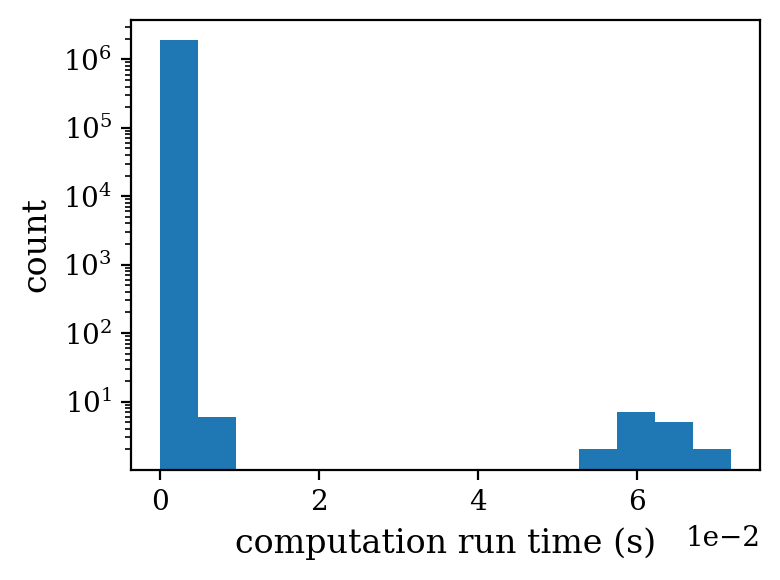

In [21]:
# use serifed font
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# create computation time histogram
plt.figure(figsize=(4,3),dpi=200)

comphist = []
for i in range(simnumber):
    comphist.append(onedronedata[i]['run_time'].tolist())

comphist = np.concatenate(comphist)
plt.hist(comphist,bins=15)
plt.ticklabel_format(style='scientific', scilimits=(0, 0), axis='x')
plt.xlabel('computation run time (s)', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.yscale('log')
plt.tight_layout()
plt.show()

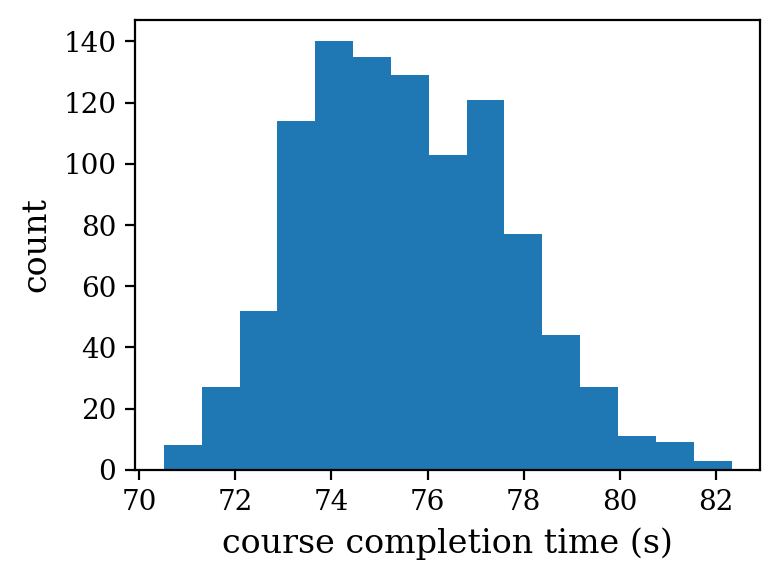

In [22]:
# create course time histogram
plt.figure(figsize=(4,3),dpi=200)

coursehist = []
for i in range(simnumber):
    coursehist.append(onedronedata[i]['t'][-1].tolist())

plt.hist(coursehist,bins=15)
plt.xlabel('course completion time (s)', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.tight_layout()
plt.show()

Run 1000 simulations with seven drones, with the rings in different positions each time

In [23]:
# define number of simulations and initialize failure counter
sevensimnumber = 1000
failnumber = 0

# turn off the viewer
simulator.disable_views() 

sevendronedata = []

for i in range(sevensimnumber):
    simulator.clear_drones()
    simulator.place_rings()
    for drone in ['drone1','drone2','drone3','drone4','drone5','drone6','drone7']:
        simulator.add_drone(Controller, drone, 'cc113.png')
    simulator.reset()
    simulator.run(max_time=100.,print_debug=False)
    for drone in ['drone1','drone2','drone3','drone4','drone5','drone6','drone7']:
        (fail, finish, time) = simulator.get_result(drone)
        if fail:
            failnumber += 1
        sevendronedata.append(simulator.get_data(drone)) # collect big list of data dictionaries
    
print(f'in {simnumber} simulations with seven drones, there were {failnumber} failures')


in 1000 simulations with seven drones, there were 566 failures


Plot observer error and controller error, first plotting error in state estimate

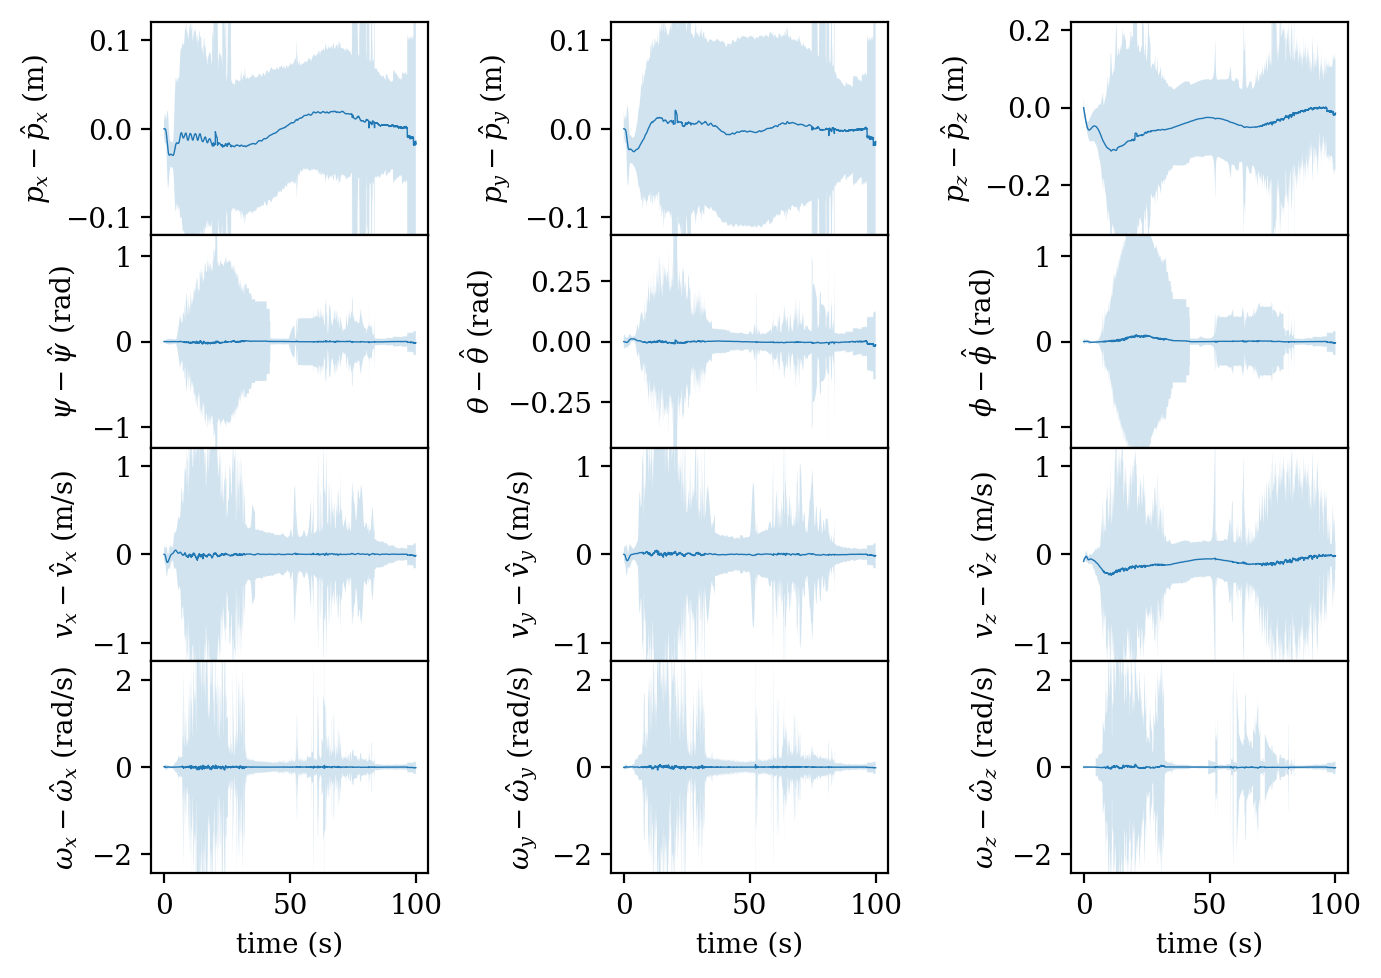

In [37]:
# plot observer error

# initialize error in state estimate arrays
p_xerror = np.zeros((sevensimnumber,2501))
p_yerror = np.zeros((sevensimnumber,2501))
p_zerror = np.zeros((sevensimnumber,2501))
yawerror = np.zeros((sevensimnumber,2501))
pitcherror = np.zeros((sevensimnumber,2501))
rollerror = np.zeros((sevensimnumber,2501))
v_xerror = np.zeros((sevensimnumber,2501))
v_yerror = np.zeros((sevensimnumber,2501))
v_zerror = np.zeros((sevensimnumber,2501))
w_xerror = np.zeros((sevensimnumber,2501))
w_yerror = np.zeros((sevensimnumber,2501))
w_zerror = np.zeros((sevensimnumber,2501))

empty = np.zeros(2501)

# assemble error arrays
for i in range(sevensimnumber):
    x = np.array([sevendronedata[i]['p_x'],sevendronedata[i]['p_y'],sevendronedata[i]['p_z'],\
                  sevendronedata[i]['yaw'],sevendronedata[i]['pitch'],sevendronedata[i]['roll'],\
                  sevendronedata[i]['v_x'],sevendronedata[i]['v_y'],sevendronedata[i]['v_z'],\
                  sevendronedata[i]['w_x'],sevendronedata[i]['w_y'],sevendronedata[i]['w_z']])
    xhat = np.array(sevendronedata[i]['xhat']).T
    
    p_xerr = np.array((x[0]-xhat[0]))
    shapedp_xerr = empty
    shapedp_xerr[:p_xerr.shape[0]]=p_xerr
    p_xerror[i,:] = shapedp_xerr
    
    p_yerr = np.array((x[1]-xhat[1]))
    shapedp_yerr = empty
    shapedp_yerr[:p_yerr.shape[0]]=p_yerr
    p_yerror[i,:] = shapedp_yerr
    
    p_zerr = np.array((x[2]-xhat[2]))
    shapedp_zerr = empty
    shapedp_zerr[:p_zerr.shape[0]]=p_zerr
    p_zerror[i,:] = shapedp_zerr
    
    yawerr = np.array((x[3]-xhat[3]))
    shapedyawerr = empty
    shapedyawerr[:yawerr.shape[0]]=yawerr
    yawerror[i,:] = shapedyawerr
    
    pitcherr = np.array((x[4]-xhat[4]))
    shapedpitcherr = empty
    shapedpitcherr[:pitcherr.shape[0]]=pitcherr
    pitcherror[i,:] = shapedpitcherr
    
    rollerr = np.array((x[5]-xhat[5]))
    shapedrollerr = empty
    shapedrollerr[:rollerr.shape[0]]=rollerr
    rollerror[i,:] = shapedrollerr
    
    v_xerr = np.array((x[6]-xhat[6]))
    shapedv_xerr = empty
    shapedv_xerr[:v_xerr.shape[0]]=v_xerr
    v_xerror[i,:] = shapedv_xerr
    
    v_yerr = np.array((x[7]-xhat[7]))
    shapedv_yerr = empty
    shapedv_yerr[:v_yerr.shape[0]]=v_yerr
    v_yerror[i,:] = shapedv_yerr
    
    v_zerr = np.array((x[8]-xhat[8]))
    shapedv_zerr = empty
    shapedv_zerr[:v_zerr.shape[0]]=v_zerr
    v_zerror[i,:] = shapedv_zerr
    
    w_xerr = np.array((x[9]-xhat[9]))
    shapedw_xerr = empty
    shapedw_xerr[:w_xerr.shape[0]]=w_xerr
    w_xerror[i,:] = shapedw_xerr
    
    w_yerr = np.array((x[10]-xhat[10]))
    shapedw_yerr = empty
    shapedw_yerr[:w_yerr.shape[0]]=w_yerr
    w_yerror[i,:] = shapedw_yerr
    
    w_zerr = np.array((x[11]-xhat[11]))
    shapedw_zerr = empty
    shapedw_zerr[:p_xerr.shape[0]]=w_zerr
    w_zerror[i,:] = shapedw_zerr
    

timelist = np.linspace(0,100,2501)

# plot the error in the state estimate mean and 3 standard deviations
fig,((axp_x,axp_y,axp_z),(axyaw,axpitch,axroll),(axv_x,axv_y,axv_z),(axw_x,axw_y,axw_z)) = plt.subplots(4,3,figsize=(7,5),dpi=200,sharex=True)

axp_x.plot(timelist,np.mean(p_xerror,axis=0),linewidth=0.5)
axp_x.fill_between(timelist,np.mean(p_xerror,axis=0)-3*np.std(p_xerror,axis=0),np.mean(p_xerror,axis=0)+3*np.std(p_xerror,axis=0),alpha=0.2)
axp_x.set_ylabel(r'$p_x-\hat{p}_x$ (m)')
axp_x.set_ylim(-0.12,0.12)

axp_y.plot(timelist,np.mean(p_yerror,axis=0),linewidth=0.5)
axp_y.fill_between(timelist,np.mean(p_yerror,axis=0)-3*np.std(p_yerror,axis=0),np.mean(p_yerror,axis=0)+3*np.std(p_yerror,axis=0),alpha=0.2)
axp_y.set_ylabel(r'$p_y-\hat{p}_y$ (m)')
axp_y.set_ylim(-0.12,0.12)

axp_z.plot(timelist,np.mean(p_zerror,axis=0),linewidth=0.5)
axp_z.fill_between(timelist,np.mean(p_zerror,axis=0)-3*np.std(p_zerror,axis=0),np.mean(p_zerror,axis=0)+3*np.std(p_zerror,axis=0),alpha=0.2)
axp_z.set_ylabel(r'$p_z-\hat{p}_z$ (m)')
axp_z.set_ylim(-0.33,0.22)

axyaw.plot(timelist,np.mean(yawerror,axis=0),linewidth=0.5)
axyaw.fill_between(timelist,np.mean(yawerror,axis=0)-3*np.std(yawerror,axis=0),np.mean(yawerror,axis=0)+3*np.std(yawerror,axis=0),alpha=0.2)
axyaw.set_ylabel(r'$\psi-\hat{\psi}$ (rad)')
axyaw.set_ylim(-1.24,1.24)

axpitch.plot(timelist,np.mean(pitcherror,axis=0),linewidth=0.5)
axpitch.fill_between(timelist,np.mean(pitcherror,axis=0)-3*np.std(pitcherror,axis=0),np.mean(pitcherror,axis=0)+3*np.std(pitcherror,axis=0),alpha=0.2)
axpitch.set_ylabel(r'$\theta-\hat{\theta}$ (rad)')
axpitch.set_ylim(-0.44,0.44)

axroll.plot(timelist,np.mean(rollerror,axis=0),linewidth=0.5)
axroll.fill_between(timelist,np.mean(rollerror,axis=0)-3*np.std(rollerror,axis=0),np.mean(rollerror,axis=0)+3*np.std(rollerror,axis=0),alpha=0.2)
axroll.set_ylabel(r'$\phi-\hat{\phi}$ (rad)')
axroll.set_ylim(-1.24,1.24)

axv_x.plot(timelist,np.mean(v_xerror,axis=0),linewidth=0.5)
axv_x.fill_between(timelist,np.mean(v_xerror,axis=0)-3*np.std(v_xerror,axis=0),np.mean(v_xerror,axis=0)+3*np.std(v_xerror,axis=0),alpha=0.2)
axv_x.set_ylabel(r'$v_x-\hat{v}_x$ (m/s)')
axv_x.set_ylim(-1.2,1.2)

axv_y.plot(timelist,np.mean(v_yerror,axis=0),linewidth=0.5)
axv_y.fill_between(timelist,np.mean(v_yerror,axis=0)-3*np.std(v_yerror,axis=0),np.mean(v_yerror,axis=0)+3*np.std(v_yerror,axis=0),alpha=0.2)
axv_y.set_ylabel(r'$v_y-\hat{v}_y$ (m/s)')
axv_y.set_ylim(-1.2,1.2)

axv_z.plot(timelist,np.mean(v_zerror,axis=0),linewidth=0.5)
axv_z.fill_between(timelist,np.mean(v_zerror,axis=0)-3*np.std(v_zerror,axis=0),np.mean(v_zerror,axis=0)+3*np.std(v_zerror,axis=0),alpha=0.2)
axv_z.set_ylabel(r'$v_z-\hat{v}_z$ (m/s)')
axv_z.set_ylim(-1.2,1.2)

axw_x.plot(timelist,np.mean(w_xerror,axis=0),linewidth=0.5)
axw_x.fill_between(timelist,np.mean(w_xerror,axis=0)-3*np.std(w_xerror,axis=0),np.mean(w_xerror,axis=0)+3*np.std(w_xerror,axis=0),alpha=0.2)
axw_x.set_ylabel(r'$\omega_x-\hat{\omega}_x$ (rad/s)')
axw_x.set_xlabel('time (s)')
axw_x.set_ylim(-2.45,2.45)

axw_y.plot(timelist,np.mean(w_yerror,axis=0),linewidth=0.5)
axw_y.fill_between(timelist,np.mean(w_yerror,axis=0)-3*np.std(w_yerror,axis=0),np.mean(w_yerror,axis=0)+3*np.std(w_yerror,axis=0),alpha=0.2)
axw_y.set_ylabel(r'$\omega_y-\hat{\omega}_y$ (rad/s)')
axw_y.set_xlabel('time (s)')
axw_y.set_ylim(-2.45,2.45)

axw_z.plot(timelist,np.mean(w_zerror,axis=0),linewidth=0.5)
axw_z.fill_between(timelist,np.mean(w_zerror,axis=0)-3*np.std(w_zerror,axis=0),np.mean(w_zerror,axis=0)+3*np.std(w_zerror,axis=0),alpha=0.2)
axw_z.set_ylabel(r'$\omega_z-\hat{\omega}_z$ (rad/s)')
axw_z.set_xlabel('time (s)')
axw_z.set_ylim(-2.45,2.45)

fig.tight_layout()
plt.subplots_adjust(hspace=0)

Create plots of state error

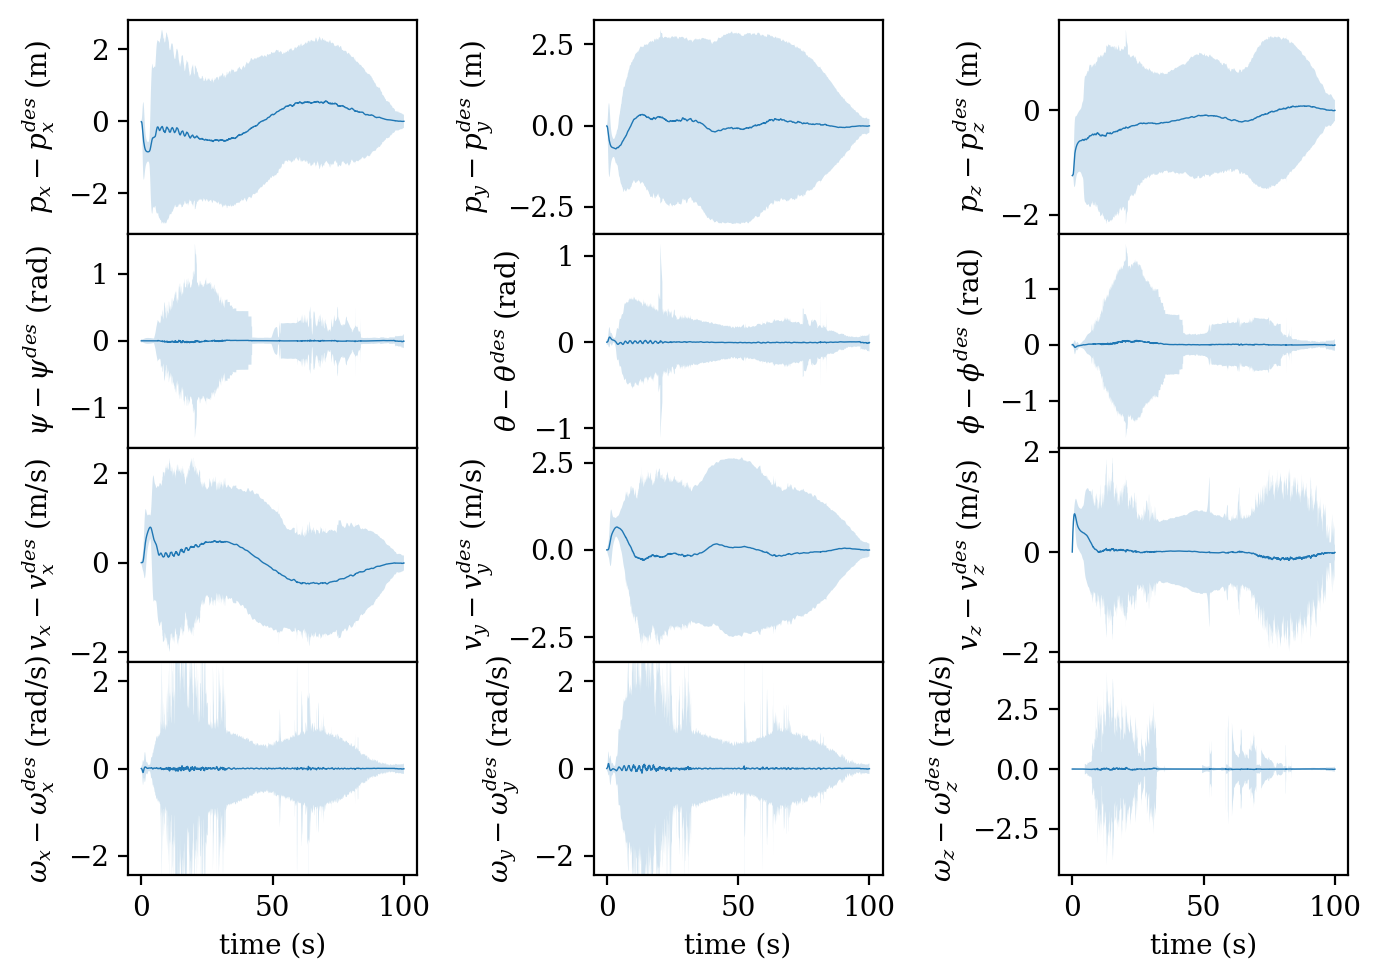

In [31]:
# plot controller error

p_xerror = np.zeros((sevensimnumber,2501))
p_yerror = np.zeros((sevensimnumber,2501))
p_zerror = np.zeros((sevensimnumber,2501))
yawerror = np.zeros((sevensimnumber,2501))
pitcherror = np.zeros((sevensimnumber,2501))
rollerror = np.zeros((sevensimnumber,2501))
v_xerror = np.zeros((sevensimnumber,2501))
v_yerror = np.zeros((sevensimnumber,2501))
v_zerror = np.zeros((sevensimnumber,2501))
w_xerror = np.zeros((sevensimnumber,2501))
w_yerror = np.zeros((sevensimnumber,2501))
w_zerror = np.zeros((sevensimnumber,2501))

empty = np.zeros(2501)

# assemble error arrays
for i in range(sevensimnumber):
    x = np.array([sevendronedata[i]['p_x'],sevendronedata[i]['p_y'],sevendronedata[i]['p_z'],\
                  sevendronedata[i]['yaw'],sevendronedata[i]['pitch'],sevendronedata[i]['roll'],\
                  sevendronedata[i]['v_x'],sevendronedata[i]['v_y'],sevendronedata[i]['v_z'],\
                  sevendronedata[i]['w_x'],sevendronedata[i]['w_y'],sevendronedata[i]['w_z']])
    xdes = np.array(sevendronedata[i]['xdes']).T
    
    p_xerr = np.array((x[0]-xdes[0]))
    shapedp_xerr = empty
    shapedp_xerr[:p_xerr.shape[0]]=p_xerr
    p_xerror[i,:] = shapedp_xerr
    
    p_yerr = np.array((x[1]-xdes[1]))
    shapedp_yerr = empty
    shapedp_yerr[:p_yerr.shape[0]]=p_yerr
    p_yerror[i,:] = shapedp_yerr
    
    p_zerr = np.array((x[2]-xdes[2]))
    shapedp_zerr = empty
    shapedp_zerr[:p_zerr.shape[0]]=p_zerr
    p_zerror[i,:] = shapedp_zerr
    
    yawerr = np.array((x[3]-xdes[3]))
    shapedyawerr = empty
    shapedyawerr[:yawerr.shape[0]]=yawerr
    yawerror[i,:] = shapedyawerr
    
    pitcherr = np.array((x[4]-xdes[4]))
    shapedpitcherr = empty
    shapedpitcherr[:pitcherr.shape[0]]=pitcherr
    pitcherror[i,:] = shapedpitcherr
    
    rollerr = np.array((x[5]-xdes[5]))
    shapedrollerr = empty
    shapedrollerr[:rollerr.shape[0]]=rollerr
    rollerror[i,:] = shapedrollerr
    
    v_xerr = np.array((x[6]-xdes[6]))
    shapedv_xerr = empty
    shapedv_xerr[:v_xerr.shape[0]]=v_xerr
    v_xerror[i,:] = shapedv_xerr
    
    v_yerr = np.array((x[7]-xdes[7]))
    shapedv_yerr = empty
    shapedv_yerr[:v_yerr.shape[0]]=v_yerr
    v_yerror[i,:] = shapedv_yerr
    
    v_zerr = np.array((x[8]-xdes[8]))
    shapedv_zerr = empty
    shapedv_zerr[:v_zerr.shape[0]]=v_zerr
    v_zerror[i,:] = shapedv_zerr
    
    w_xerr = np.array((x[9]-xdes[9]))
    shapedw_xerr = empty
    shapedw_xerr[:w_xerr.shape[0]]=w_xerr
    w_xerror[i,:] = shapedw_xerr
    
    w_yerr = np.array((x[10]-xdes[10]))
    shapedw_yerr = empty
    shapedw_yerr[:w_yerr.shape[0]]=w_yerr
    w_yerror[i,:] = shapedw_yerr
    
    w_zerr = np.array((x[11]-xdes[11]))
    shapedw_zerr = empty
    shapedw_zerr[:p_xerr.shape[0]]=w_zerr
    w_zerror[i,:] = shapedw_zerr
    

timelist = np.linspace(0,100,2501)

# plot the error in the state mean and 3 standard deviations
fig,((axp_x,axp_y,axp_z),(axyaw,axpitch,axroll),(axv_x,axv_y,axv_z),(axw_x,axw_y,axw_z)) = plt.subplots(4,3,figsize=(7,5),dpi=200,sharex=True)

axp_x.plot(timelist,np.mean(p_xerror,axis=0),linewidth=0.5)
axp_x.fill_between(timelist,np.mean(p_xerror,axis=0)-3*np.std(p_xerror,axis=0),np.mean(p_xerror,axis=0)+3*np.std(p_xerror,axis=0),alpha=0.2)
axp_x.set_ylabel(r'$p_x-p_{x}^{des}$ (m)')

axp_y.plot(timelist,np.mean(p_yerror,axis=0),linewidth=0.5)
axp_y.fill_between(timelist,np.mean(p_yerror,axis=0)-3*np.std(p_yerror,axis=0),np.mean(p_yerror,axis=0)+3*np.std(p_yerror,axis=0),alpha=0.2)
axp_y.set_ylabel(r'$p_y-p_{y}^{des}$ (m)')

axp_z.plot(timelist,np.mean(p_zerror,axis=0),linewidth=0.5)
axp_z.fill_between(timelist,np.mean(p_zerror,axis=0)-3*np.std(p_zerror,axis=0),np.mean(p_zerror,axis=0)+3*np.std(p_zerror,axis=0),alpha=0.2)
axp_z.set_ylabel(r'$p_z-p_{z}^{des}$ (m)')

axyaw.plot(timelist,np.mean(yawerror,axis=0),linewidth=0.5)
axyaw.fill_between(timelist,np.mean(yawerror,axis=0)-3*np.std(yawerror,axis=0),np.mean(yawerror,axis=0)+3*np.std(yawerror,axis=0),alpha=0.2)
axyaw.set_ylabel(r'$\psi-\psi^{des}$ (rad)')

axpitch.plot(timelist,np.mean(pitcherror,axis=0),linewidth=0.5)
axpitch.fill_between(timelist,np.mean(pitcherror,axis=0)-3*np.std(pitcherror,axis=0),np.mean(pitcherror,axis=0)+3*np.std(pitcherror,axis=0),alpha=0.2)
axpitch.set_ylabel(r'$\theta-\theta^{des}$ (rad)')

axroll.plot(timelist,np.mean(rollerror,axis=0),linewidth=0.5)
axroll.fill_between(timelist,np.mean(rollerror,axis=0)-3*np.std(rollerror,axis=0),np.mean(rollerror,axis=0)+3*np.std(rollerror,axis=0),alpha=0.2)
axroll.set_ylabel(r'$\phi-\phi^{des}$ (rad)')

axv_x.plot(timelist,np.mean(v_xerror,axis=0),linewidth=0.5)
axv_x.fill_between(timelist,np.mean(v_xerror,axis=0)-3*np.std(v_xerror,axis=0),np.mean(v_xerror,axis=0)+3*np.std(v_xerror,axis=0),alpha=0.2)
axv_x.set_ylabel(r'$v_x-v_{x}^{des}$ (m/s)')

axv_y.plot(timelist,np.mean(v_yerror,axis=0),linewidth=0.5)
axv_y.fill_between(timelist,np.mean(v_yerror,axis=0)-3*np.std(v_yerror,axis=0),np.mean(v_yerror,axis=0)+3*np.std(v_yerror,axis=0),alpha=0.2)
axv_y.set_ylabel(r'$v_y-v_{y}^{des}$ (m/s)')

axv_z.plot(timelist,np.mean(v_zerror,axis=0),linewidth=0.5)
axv_z.fill_between(timelist,np.mean(v_zerror,axis=0)-3*np.std(v_zerror,axis=0),np.mean(v_zerror,axis=0)+3*np.std(v_zerror,axis=0),alpha=0.2)
axv_z.set_ylabel(r'$v_z-v_{z}^{des}$ (m/s)')

axw_x.plot(timelist,np.mean(w_xerror,axis=0),linewidth=0.5)
axw_x.fill_between(timelist,np.mean(w_xerror,axis=0)-3*np.std(w_xerror,axis=0),np.mean(w_xerror,axis=0)+3*np.std(w_xerror,axis=0),alpha=0.2)
axw_x.set_ylabel(r'$\omega_x-\omega_{x}^{des}$ (rad/s)')
axw_x.set_xlabel('time (s)')
axw_x.set_ylim(-2.45,2.45)

axw_y.plot(timelist,np.mean(w_yerror,axis=0),linewidth=0.5)
axw_y.fill_between(timelist,np.mean(w_yerror,axis=0)-3*np.std(w_yerror,axis=0),np.mean(w_yerror,axis=0)+3*np.std(w_yerror,axis=0),alpha=0.2)
axw_y.set_ylabel(r'$\omega_y-\omega_{y}^{des}$ (rad/s)')
axw_y.set_xlabel('time (s)')
axw_y.set_ylim(-2.45,2.45)

axw_z.plot(timelist,np.mean(w_zerror,axis=0),linewidth=0.5)
axw_z.fill_between(timelist,np.mean(w_zerror,axis=0)-3*np.std(w_zerror,axis=0),np.mean(w_zerror,axis=0)+3*np.std(w_zerror,axis=0),alpha=0.2)
axw_z.set_ylabel(r'$\omega_z-\omega_{z}^{des}$ (rad/s)')
axw_z.set_xlabel('time (s)')

fig.tight_layout()
plt.subplots_adjust(hspace=0)